# Social media sentiment analysis: Use natural language processing techniques to analyze social media posts and identify trends in public opinion on a particular topic.

In [ ]:
import re
import nltk
import string
import spacy

import numpy as np
import pandas as pd
from spacy import displacy

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from keras.utils import pad_sequences
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer

from keras.optimizers import Adam
from keras.optimizers import SGD

from keras.metrics import Precision, Recall
from keras.layers import Dense
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import BatchNormalization
from keras.layers import Attention
from keras.layers import Concatenate, Dense, Input
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer

from keras import Model
from keras.layers import Layer
from keras.utils import plot_model

import keras.backend as K

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split

nltk.download('stopwords')
nltk.download('punkt')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv
/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv
/kaggle/input/twitter-sentiment-analysis-1m-data/twitter_final_Dataset.csv
/kaggle/input/twitter-sentiment-analysis-1m-data/twitter_cleared_Dataset.csv
/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv


## Twitter covid-19-nlp-text-classification dataset

In [ ]:
twitter_training = pd.read_csv("/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv", encoding='latin1')
twitter_validation = pd.read_csv("/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv")

In [ ]:
twitter_training["Sentiment"].unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

In [ ]:
twitter_original = twitter_training.copy()
twitter_training.head(10)

UserName  ScreenName                   Location     TweetAt  \
0      3799       48751                     London  16-03-2020   
1      3800       48752                         UK  16-03-2020   
2      3801       48753                  Vagabonds  16-03-2020   
3      3802       48754                        NaN  16-03-2020   
4      3803       48755                        NaN  16-03-2020   
5      3804       48756  ÃT: 36.319708,-82.363649  16-03-2020   
6      3805       48757       35.926541,-78.753267  16-03-2020   
7      3806       48758                    Austria  16-03-2020   
8      3807       48759            Atlanta, GA USA  16-03-2020   
9      3808       48760           BHAVNAGAR,GUJRAT  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative  
5  As news of the regionÂs first confirmed COVID...            Positive  
6  Cashier at grocery store was sharing his insig...            Positive  
7  Was at the supermarket today. Didn't buy toile...             Neutral  
8  Due to COVID-19 our retail store and classroom...            Positive  
9  For corona prevention,we should stop to buy th...            Negative

<AxesSubplot:title={'center':'Number for each sentiment in Twitter dataset'}>

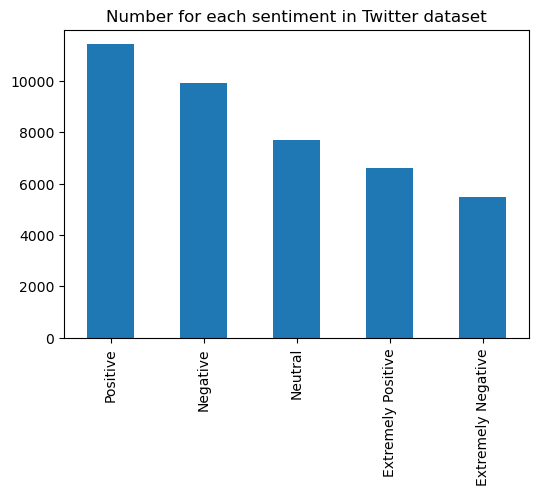

In [ ]:
twitter_training["Sentiment"].value_counts().plot(kind='bar',
                                    figsize=(6,4),
                                    title="Number for each sentiment in Twitter dataset")

<AxesSubplot:title={'center':'Number for each tweet per date'}>

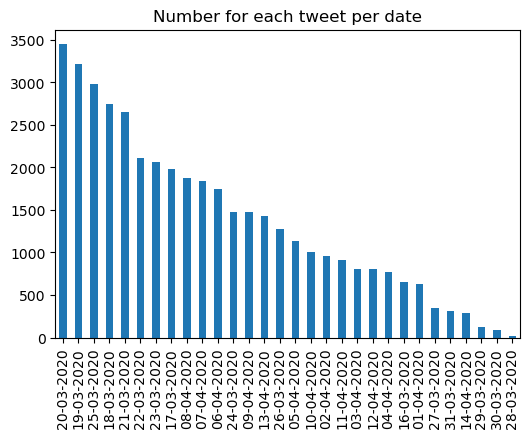

In [ ]:
twitter_training["TweetAt"].value_counts().plot(kind='bar',
                                    figsize=(6,4),
                                    title="Number for each tweet per date")

## Data preprocessing

In [ ]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text) # Remove special char
    text = re.sub(r'<.*?>', '', text) # Remove html tags
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    text = ' '.join(tokens)

    return text

twitter_training['OriginalTweet'] = twitter_training['OriginalTweet'].astype(str)
twitter_validation['OriginalTweet'] = twitter_validation['OriginalTweet'].astype(str)
twitter_training['OriginalTweet'] = twitter_training['OriginalTweet'].apply(normalize_text)
twitter_validation['OriginalTweet'] = twitter_validation['OriginalTweet'].apply(normalize_text)

In [ ]:
twitter_training.head(10)

UserName  ScreenName                   Location     TweetAt  \
0      3799       48751                     London  16-03-2020   
1      3800       48752                         UK  16-03-2020   
2      3801       48753                  Vagabonds  16-03-2020   
3      3802       48754                        NaN  16-03-2020   
4      3803       48755                        NaN  16-03-2020   
5      3804       48756  ÃT: 36.319708,-82.363649  16-03-2020   
6      3805       48757       35.926541,-78.753267  16-03-2020   
7      3806       48758                    Austria  16-03-2020   
8      3807       48759            Atlanta, GA USA  16-03-2020   
9      3808       48760           BHAVNAGAR,GUJRAT  16-03-2020   

                                       OriginalTweet           Sentiment  
0  menyrbi philgahan chrisitv httpstcoifzfanpa ht...             Neutral  
1  advic talk neighbour famili exchang phone numb...            Positive  
2  coronaviru australia woolworth give elderli di...            Positive  
3  food stock one empti pleas dont panic enough f...            Positive  
4  readi go supermarket covid outbreak im paranoi...  Extremely Negative  
5  news regionâ first confirm covid case came sul...            Positive  
6  cashier groceri store share insight covid prov...            Positive  
7  supermarket today didnt buy toilet paper rebel...             Neutral  
8  due covid retail store classroom atlanta open ...            Positive  
9  corona preventionw stop buy thing cash use onl...            Negative

In [ ]:
sample_original = twitter_original["OriginalTweet"][20]
sample_original

'with 100  nations inficted with  covid  19  the world must  not  play fair with china  100 goverments must demand  china  adopts new guilde  lines on food safty  the  chinese  goverment  is guilty of  being  irosponcible   with life  on a global scale'

In [ ]:
from sklearn.preprocessing import OneHotEncoder

one_hot = OneHotEncoder(sparse=False)
one_hot.fit(twitter_training[["Sentiment"]])

OneHotEncoder(sparse=False)

In [ ]:
y_one_hot_train = one_hot.transform(twitter_training[["Sentiment"]])
y_one_hot_test = one_hot.transform(twitter_validation[["Sentiment"]])

## Sentiments word clouds

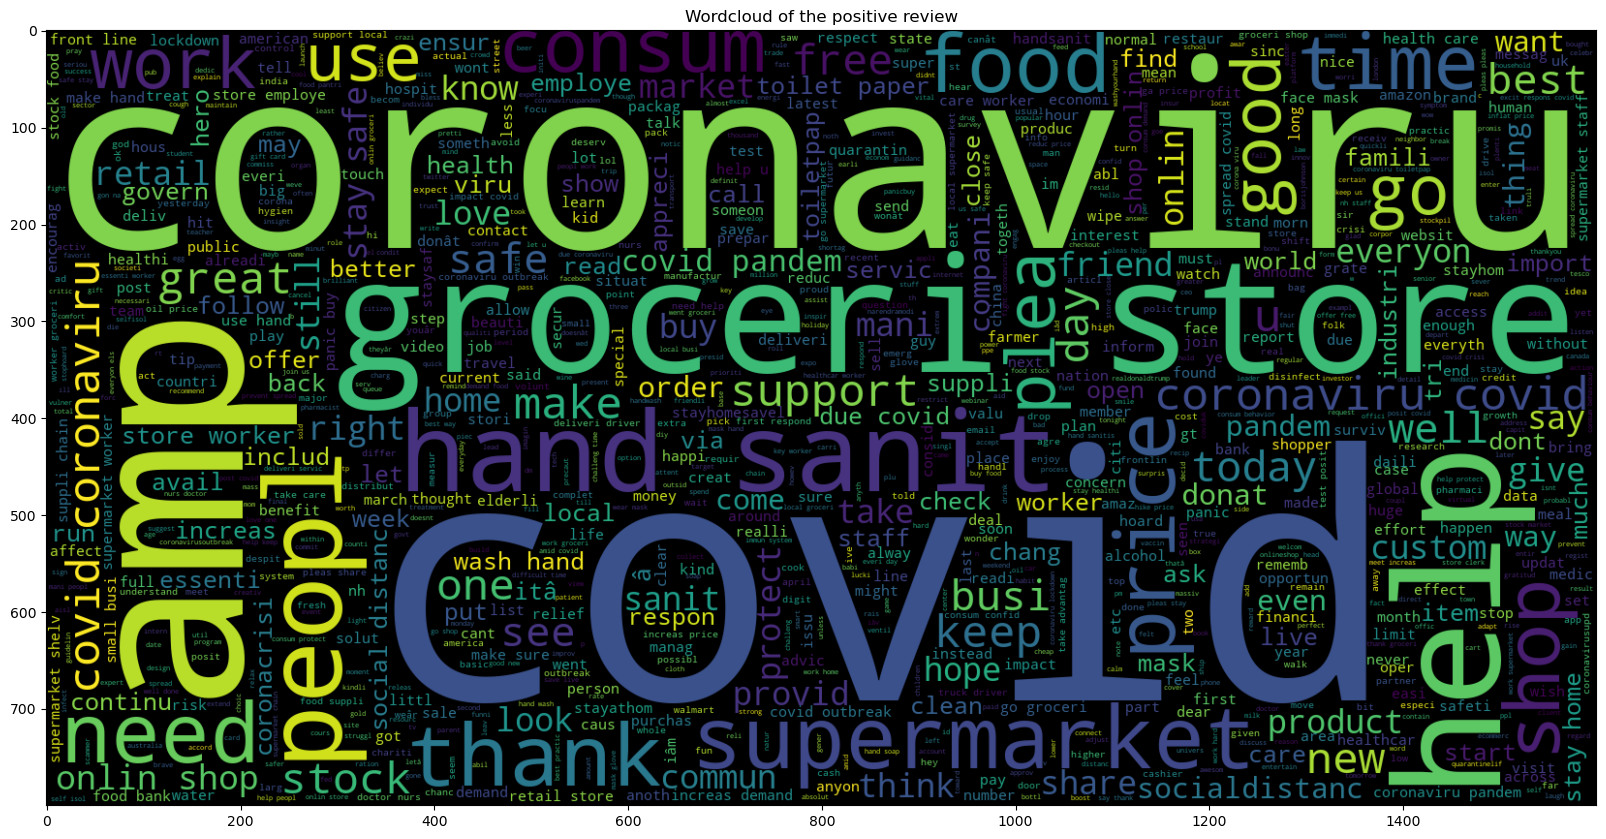

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words=1000 , width=1600 , height=800).generate(" ".join(twitter_training[twitter_training["Sentiment"] == "Extremely Positive"]["OriginalTweet"]))
plt.title("Wordcloud of the positive review")
plt.imshow(wc, interpolation = 'bilinear')

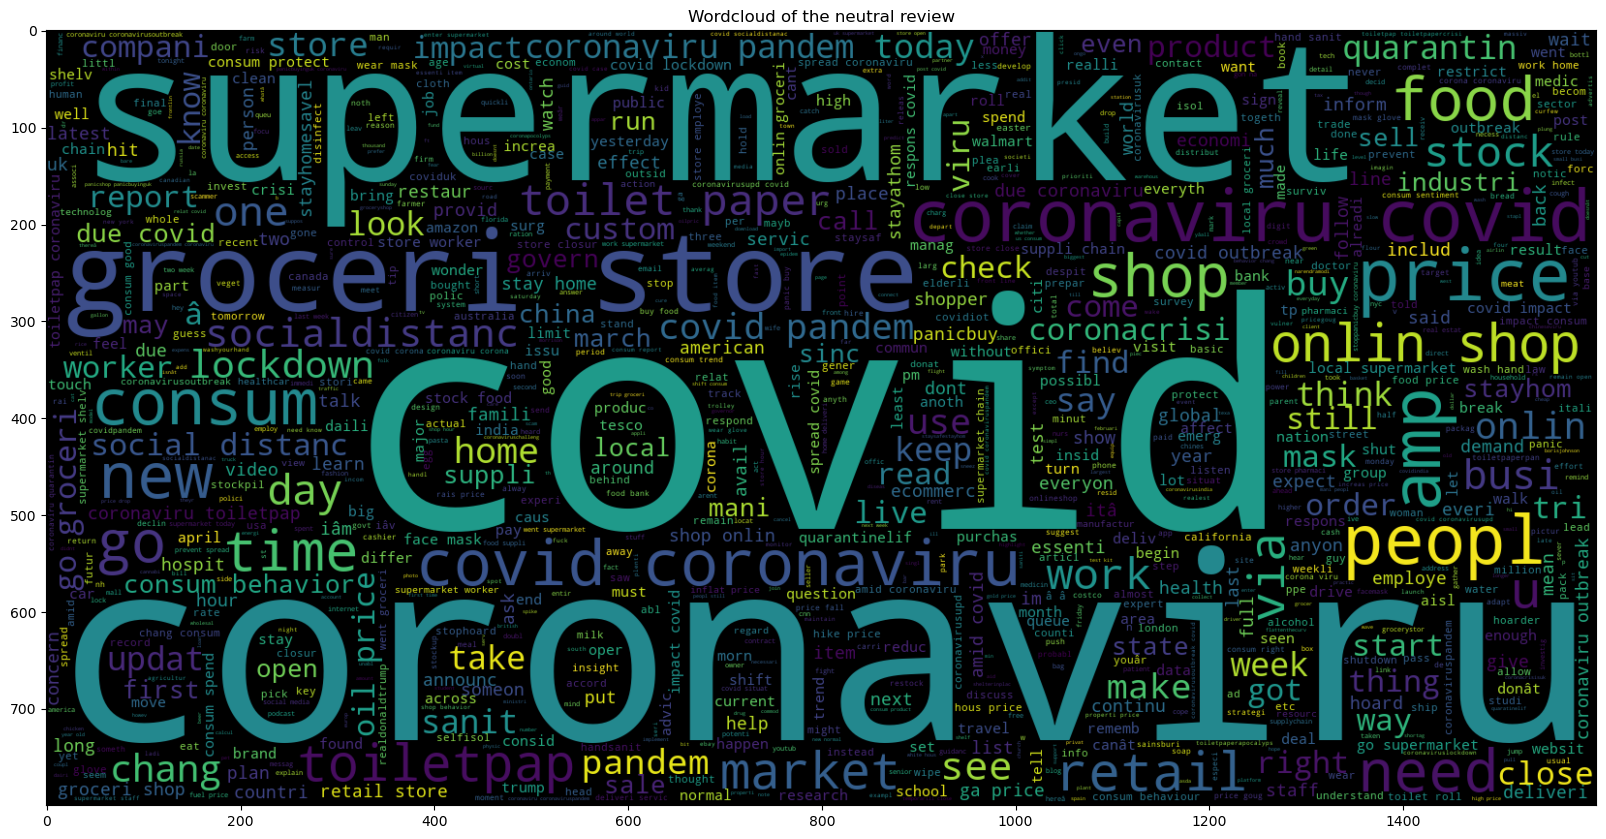

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words=1000 , width=1600 , height=800).generate(" ".join(twitter_training[twitter_training["Sentiment"] == "Neutral"]["OriginalTweet"]))
plt.title("Wordcloud of the neutral review")
plt.imshow(wc, interpolation = 'bilinear')

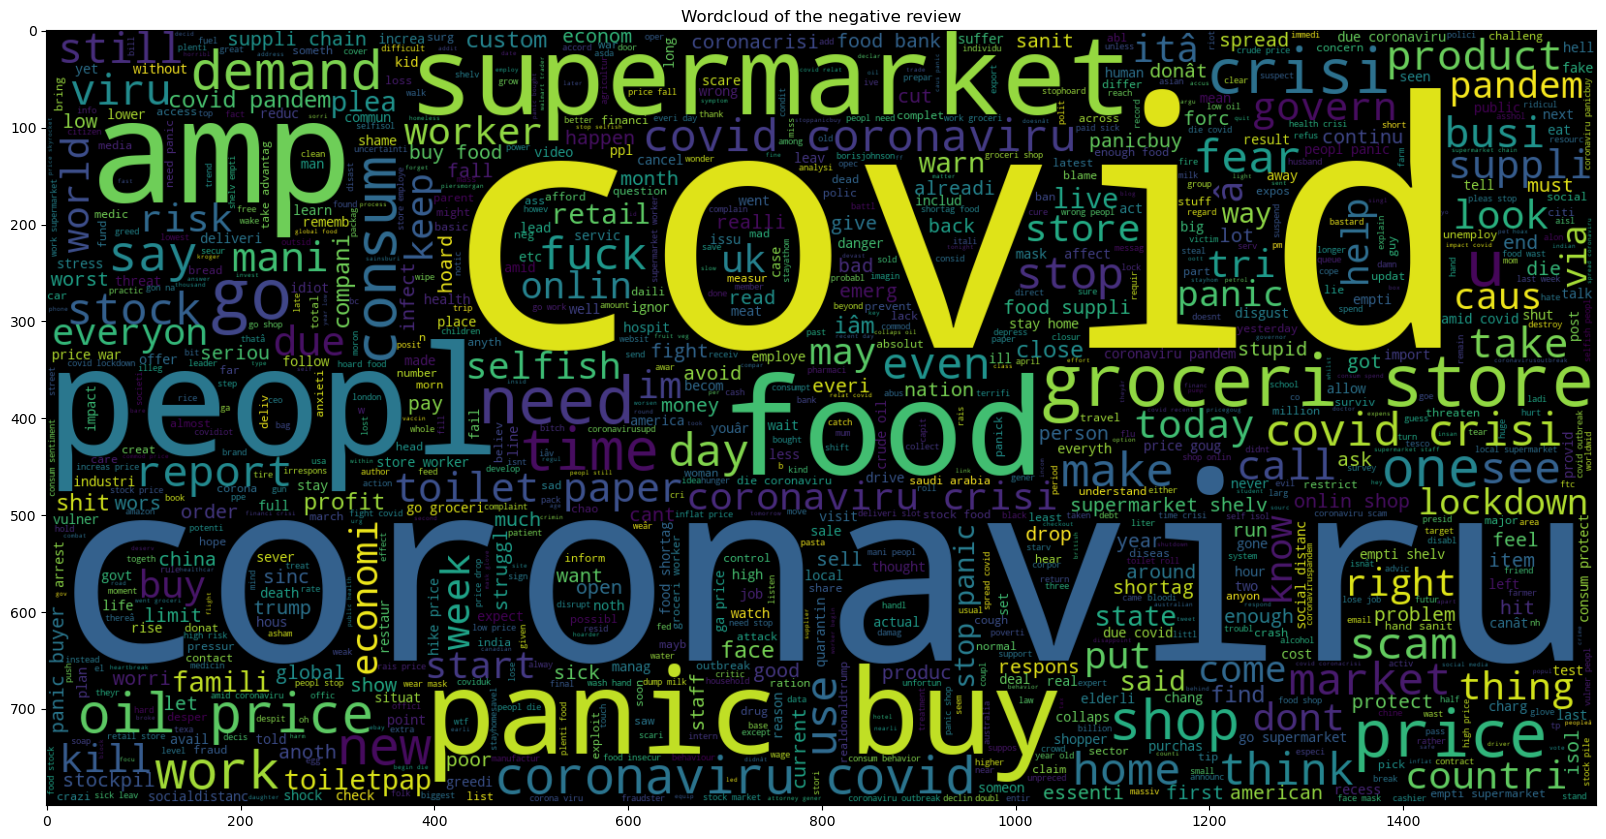

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words=1000 , width=1600 , height=800).generate(" ".join(twitter_training[twitter_training["Sentiment"] == "Extremely Negative"]["OriginalTweet"]))
plt.title("Wordcloud of the negative review")
plt.imshow(wc, interpolation = 'bilinear')

## Tokenization

In [ ]:
def fit_transform(tokenizer, text):
    return pad_sequences(tokenizer.texts_to_sequences(text), padding='post', maxlen=max_len)


max_len, max_features = 628, 1000
tokenizer_keras = Tokenizer(num_words=max_features, split=" ")
tokenizer_keras.fit_on_texts(twitter_training["OriginalTweet"])
X = fit_transform(tokenizer_keras, twitter_training["OriginalTweet"])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot_train, random_state=42, stratify=twitter_training["Sentiment"], test_size=0.2)

In [ ]:
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (32925, 628)
Test shape: (8232, 628)


## The NLP Model - Sentiment Analysis


In [ ]:

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1),
                               initializer='zeros', trainable=True)
        super(attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        e = K.squeeze(e, axis=-1)
        alpha = K.softmax(e)
        alpha = K.expand_dims(alpha, axis=-1)
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

def lstm_model(input_len, max_features=10000, embed_size=128):
    input_layer = Input(shape=(input_len,), dtype="int32")
    embedded_layer = Embedding(max_features, embed_size)(input_layer)
    lstm_layer = Bidirectional(LSTM(64, return_sequences = True))(embedded_layer)
    attention_layer = attention()(lstm_layer)
    output_layer = Dense(5, activation='softmax')(attention_layer)

    model = Model(input_layer, output_layer)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3),
                  metrics=['accuracy'])
    return model

In [ ]:
model = lstm_model(input_len=628, max_features=10000, embed_size=128)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 628)]             0         
                                                                 
 embedding (Embedding)       (None, 628, 128)          1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 628, 128)         98816     
 l)                                                              
                                                                 
 attention (attention)       (None, 128)               756       
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                                 
Total params: 1,380,217
Trainable params: 1,380,217
Non-trainable params: 0
___________________________________________________

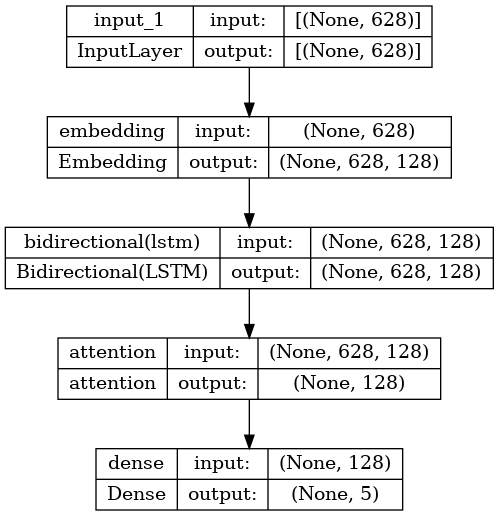

In [ ]:
plot_model(model, to_file="model.png", show_shapes=True)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [ ]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32,
                                      verbose=1, callbacks=[early_stopping])

Epoch 1/30
1029/1029 [==============================] - 78s 69ms/step - loss: 1.3435 - accuracy: 0.4211
Epoch 2/30
1029/1029 [==============================] - 72s 70ms/step - loss: 1.0309 - accuracy: 0.6070
Epoch 3/30
1029/1029 [==============================] - 72s 70ms/step - loss: 0.9934 - accuracy: 0.6244
Epoch 4/30
1029/1029 [==============================] - 72s 70ms/step - loss: 0.9732 - accuracy: 0.6336
Epoch 5/30
1029/1029 [==============================] - 72s 70ms/step - loss: 0.9490 - accuracy: 0.6433
Epoch 6/30
1029/1029 [==============================] - 72s 70ms/step - loss: 0.9254 - accuracy: 0.6537
Epoch 7/30
1029/1029 [==============================] - 72s 70ms/step - loss: 0.9016 - accuracy: 0.6639
Epoch 8/30
1029/1029 [==============================] - 72s 70ms/step - loss: 0.8819 - accuracy: 0.6733
Epoch 9/30
1029/1029 [==============================] - 71s 69ms/step - loss: 0.8574 - accuracy: 0.6845
Epoch 10/30
1029/1029 [==============================] - 71s 69m

<Figure size 640x480 with 0 Axes>

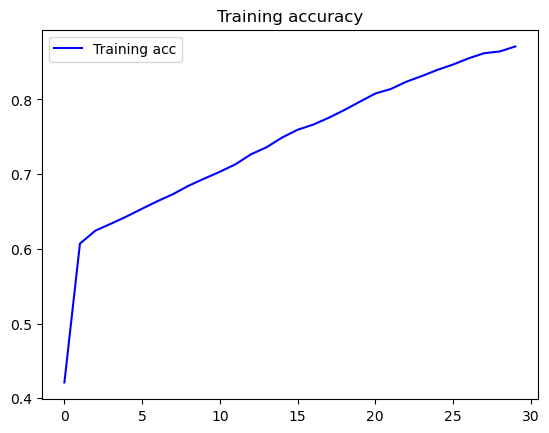

<Figure size 640x480 with 0 Axes>

In [ ]:
history_ = history.history
acc, loss = history_["accuracy"], history_["loss"]
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.title('Training accuracy')
plt.legend()

plt.figure()

<Figure size 640x480 with 0 Axes>

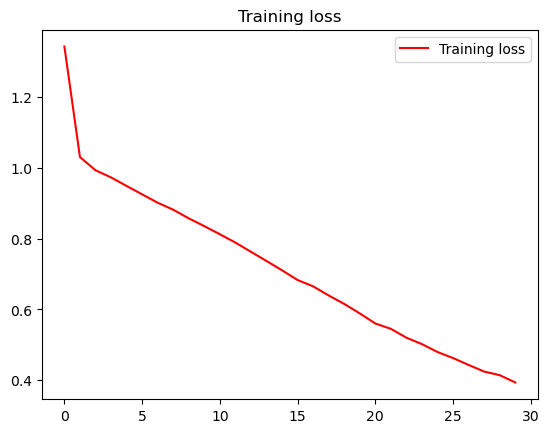

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend()

plt.figure()

In [ ]:
X_samples_val = twitter_validation["OriginalTweet"]
y_samples_val = one_hot.transform(twitter_validation[["Sentiment"]])

In [ ]:
import tensorflow as tf

def get_predict(model, tokenizer, sample):
    m_proba = model.predict(fit_transform(tokenizer, [sample]), verbose=0)
    res_one_hot_vec = tf.one_hot(tf.argmax(m_proba[0]), 5)
    result = one_hot.inverse_transform([res_one_hot_vec])
    return result[0][0]


def get_val_pred(index):
    prediction = get_predict(model, tokenizer_keras, X_samples_val.loc[index]), f"-> Real: {one_hot.inverse_transform([y_samples_val[index]])}"
    print(prediction)
    return prediction


In [ ]:
get_val_pred(35)
get_val_pred(54)
get_val_pred(19)
get_val_pred(14)


('Extremely Negative', "-> Real: [['Extremely Negative']]")
('Positive', "-> Real: [['Extremely Negative']]")
('Extremely Positive', "-> Real: [['Extremely Positive']]")
('Positive', "-> Real: [['Positive']]")


('Positive', "-> Real: [['Positive']]")

In [ ]:
nlp = spacy.load('en_core_web_sm')

### Sample sentiment analysis

In [ ]:
my_text_sample = "Find out how you can protect yourself and loved ones from coronavirus"
get_predict(model, tokenizer_keras, normalize_text(my_text_sample))

'Extremely Positive'

In [ ]:
my_text_sample = "Panic food buying in Germany due to #coronavirus has begun."
get_predict(model, tokenizer_keras, normalize_text(my_text_sample))

'Negative'

## Topic clustering and naming

In [ ]:
import pandas as pd

In [ ]:
twitter_lst = twitter_training['OriginalTweet'].to_list()

In [ ]:
! pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 70.9 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp37-cp37m-linux_x86_64.whl size=3430478 sha256=0df41eab4e0327a56cd6482f317c21a5a2190024b70cbc40049d036d3a06d56e
  Stored in directory: /root/.cache/pip/wheels/e5/7d/a3/71a87d8d1959fe351849defe5b2e7bc51c73915af79ea8bcbd
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=19bb80fc727e7b586ae4c78dc6edb73649e4da01f9a2796d79218cf109f19948
  Stored in directory: /root/.cache/pip/wheels/83/71/2b/40d17d21937fed496fb99145227eca8f2

In [ ]:
from bertopic import BERTopic

In [ ]:
topic_model = BERTopic(verbose=True)
topics, probs = topic_model.fit_transform(twitter_lst)

2024-03-26 17:47:24,297 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/1287 [00:00<?, ?it/s]

2024-03-26 17:47:55,818 - BERTopic - Embedding - Completed ✓
2024-03-26 17:47:55,820 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-26 17:48:46,157 - BERTopic - Dimensionality - Completed ✓
2024-03-26 17:48:46,159 - BERTopic - Cluster - Start clustering the reduced embeddings


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2024-03-26 17:48:51,025 - BERTopic - Cluster - Completed ✓
2024-03-26 17:48:51,040 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-03-26 17:48:53,309 - BERTopic - Representation - Completed ✓


In [ ]:
original_text = pd.read_csv("/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv", encoding='latin1')

In [ ]:
def get_topics_by_id(topic_id):
    indices_topics_by_id = np.argwhere(np.asarray(topics) == topic_id).astype(np.int32).reshape(-1)
    topics_by_id_original = [original_text["OriginalTweet"][i] for i in indices_topics_by_id]
    topics_by_id_preprocessed = [twitter_lst[i] for i in indices_topics_by_id]
    return topics_by_id_original, topics_by_id_preprocessed

In [ ]:
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer, pipeline
from random import sample

tokenizer_t5 = T5Tokenizer.from_pretrained("t5-base")
language_model = T5ForConditionalGeneration.from_pretrained("t5-base")
headline_generator = T5ForConditionalGeneration.from_pretrained("Michau/t5-base-en-generate-headline")

summarizer = pipeline("summarization", model=language_model, tokenizer=tokenizer_t5, framework="tf")


In [ ]:
def generate_topic_label(articles: list) -> str:
    summary_list = []
    current_token_length = 0
    max_token_length = 512

    for article in sample(articles, k=len(articles)):
        summary = summarizer(article)[0]["summary_text"]
        current_token_length += len(tokenizer_t5.encode(summary))
        if current_token_length >= max_token_length:
            break
        summary_list.append(summary)

    encoding = tokenizer_t5.encode("headline: " + " ".join(summary_list), return_tensors="pt")
    output = headline_generator.generate(encoding)

    return tokenizer_t5.decode(output[0][1:-1])


In [ ]:
def analyze_topic_sentiment(tweets_preprocessed):
    list_semantics = []
    for tweet in tweets_preprocessed:
        list_semantics.append(get_predict(model, tokenizer_keras, tweet))
    return list_semantics

In [ ]:
list_analysis = []
for i in range(15):
    topics_by_id_original, topics_by_id_preprocessed = get_topics_by_id(i)
    title = generate_topic_label(topics_by_id_original)
    output_predictions = model.predict(fit_transform(tokenizer_keras, topics_by_id_preprocessed), verbose=0)
    print(title)
    res_one_hot_vec = one_hot.inverse_transform(output_predictions)
    unique, counts = np.unique(res_one_hot_vec, return_counts=True)
    print(np.asarray((unique, counts)).T)

    list_analysis.append((title, unique, counts))

    print('*******************')



Your max_length is set to 200, but you input_length is only 75. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Your max_length is set to 200, but you input_length is only 36. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 200, but you input_length is only 75. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Your max_length is set to 200, but you input_length is only 54. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 200, but you input_length is only 58. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 200, but you input_length is only 133. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=66)
Your max_length is set to 200, but you input_length is only 41. You might conside

Toilet Paper Crisis 2020
[['Extremely Negative' 156]
 ['Extremely Positive' 229]
 ['Negative' 337]
 ['Neutral' 761]
 ['Positive' 480]]
*******************


Your max_length is set to 200, but you input_length is only 20. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 200, but you input_length is only 67. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 200, but you input_length is only 38. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 200, but you input_length is only 89. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 200, but you input_length is only 55. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 200, but you input_length is only 50. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 200, but you input_length is only 68. You might consider

COVID-19 - The Second Leading Cause of Death in the U.S.
[['Extremely Negative' 162]
 ['Extremely Positive' 476]
 ['Negative' 345]
 ['Neutral' 239]
 ['Positive' 616]]
*******************


Your max_length is set to 200, but you input_length is only 85. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 200, but you input_length is only 81. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 200, but you input_length is only 77. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 200, but you input_length is only 53. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 200, but you input_length is only 47. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)
Your max_length is set to 200, but you input_length is only 68. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 200, but you input_length is only 51. You might consider

Oil Prices Fall in Oversupply Concerns
[['Extremely Negative' 425]
 ['Extremely Positive' 65]
 ['Negative' 581]
 ['Neutral' 238]
 ['Positive' 284]]
*******************


Your max_length is set to 200, but you input_length is only 43. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 200, but you input_length is only 87. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 200, but you input_length is only 43. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 200, but you input_length is only 68. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 200, but you input_length is only 78. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 200, but you input_length is only 50. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 200, but you input_length is only 65. You might consider

Covid-19 - The New Normal
[['Extremely Negative' 131]
 ['Extremely Positive' 282]
 ['Negative' 263]
 ['Neutral' 332]
 ['Positive' 428]]
*******************


Your max_length is set to 200, but you input_length is only 35. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 200, but you input_length is only 48. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 200, but you input_length is only 86. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 200, but you input_length is only 46. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)
Your max_length is set to 200, but you input_length is only 53. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 200, but you input_length is only 105. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 200, but you input_length is only 66. You might conside

#COVID 2019: #EU Commission Working Together to Combat Spread of Fake Products
[['Extremely Negative' 292]
 ['Extremely Positive' 47]
 ['Negative' 240]
 ['Neutral' 58]
 ['Positive' 112]]
*******************


Your max_length is set to 200, but you input_length is only 58. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 200, but you input_length is only 40. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 200, but you input_length is only 55. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 200, but you input_length is only 41. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 200, but you input_length is only 66. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 200, but you input_length is only 81. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 200, but you input_length is only 62. You might consider

Covid-19 - A Supermarket Is Now Your Main Risk at Spreading Cor
[['Extremely Negative' 61]
 ['Extremely Positive' 63]
 ['Negative' 144]
 ['Neutral' 275]
 ['Positive' 163]]
*******************


Your max_length is set to 200, but you input_length is only 97. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)
Your max_length is set to 200, but you input_length is only 45. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 200, but you input_length is only 64. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 200, but you input_length is only 68. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 200, but you input_length is only 95. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 200, but you input_length is only 43. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 200, but you input_length is only 82. You might consider

Branding in the Post-Coronavirus Pandemic
[['Extremely Negative' 39]
 ['Extremely Positive' 92]
 ['Negative' 81]
 ['Neutral' 304]
 ['Positive' 188]]
*******************


Your max_length is set to 200, but you input_length is only 49. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 200, but you input_length is only 33. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 200, but you input_length is only 81. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 200, but you input_length is only 35. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 200, but you input_length is only 113. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)
Your max_length is set to 200, but you input_length is only 53. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 200, but you input_length is only 45. You might conside

COVID-19 - Why is Everyone in Town at the Grocery Store?
[['Extremely Negative' 42]
 ['Extremely Positive' 65]
 ['Negative' 124]
 ['Neutral' 301]
 ['Positive' 167]]
*******************


Your max_length is set to 200, but you input_length is only 44. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 200, but you input_length is only 55. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 200, but you input_length is only 51. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 200, but you input_length is only 56. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 200, but you input_length is only 52. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 200, but you input_length is only 56. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 200, but you input_length is only 36. You might consider

Coronavirus - #COVID19 #covid19 #quarant
[['Extremely Negative' 354]
 ['Extremely Positive' 35]
 ['Negative' 214]
 ['Neutral' 26]
 ['Positive' 48]]
*******************


Your max_length is set to 200, but you input_length is only 72. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 200, but you input_length is only 34. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 200, but you input_length is only 38. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 200, but you input_length is only 58. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 200, but you input_length is only 21. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 200, but you input_length is only 41. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 200, but you input_length is only 41. You might consider

Help COVID 19 - Food Banks in Your Community
[['Extremely Negative' 25]
 ['Extremely Positive' 66]
 ['Negative' 123]
 ['Neutral' 21]
 ['Positive' 120]]
*******************


Your max_length is set to 200, but you input_length is only 93. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 200, but you input_length is only 82. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 200, but you input_length is only 41. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 200, but you input_length is only 130. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=65)
Your max_length is set to 200, but you input_length is only 61. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 200, but you input_length is only 95. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 200, but you input_length is only 72. You might conside

Coronavirus - The New Normal
[['Extremely Negative' 36]
 ['Extremely Positive' 96]
 ['Negative' 54]
 ['Neutral' 47]
 ['Positive' 118]]
*******************


Your max_length is set to 200, but you input_length is only 63. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 200, but you input_length is only 94. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 200, but you input_length is only 55. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 200, but you input_length is only 76. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 200, but you input_length is only 66. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 200, but you input_length is only 88. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 200, but you input_length is only 58. You might consider

Retailers Adjust Store Hours, Focus on Employees During COVID-19
[['Extremely Negative' 8]
 ['Extremely Positive' 57]
 ['Negative' 31]
 ['Neutral' 147]
 ['Positive' 94]]
*******************


Your max_length is set to 200, but you input_length is only 64. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 200, but you input_length is only 59. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 200, but you input_length is only 53. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 200, but you input_length is only 71. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 200, but you input_length is only 85. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 200, but you input_length is only 80. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 200, but you input_length is only 95. You might consider

Coronavirus - Trump Invokes Defense Production Act - allowing For
[['Extremely Negative' 68]
 ['Extremely Positive' 49]
 ['Negative' 60]
 ['Neutral' 46]
 ['Positive' 82]]
*******************


Your max_length is set to 200, but you input_length is only 51. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 200, but you input_length is only 60. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 200, but you input_length is only 52. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 200, but you input_length is only 70. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 200, but you input_length is only 111. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 200, but you input_length is only 87. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 200, but you input_length is only 123. You might consid

COVID-19 - Hand Sanitizer
[['Extremely Negative' 3]
 ['Extremely Positive' 79]
 ['Negative' 6]
 ['Neutral' 19]
 ['Positive' 132]]
*******************


Your max_length is set to 200, but you input_length is only 99. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 200, but you input_length is only 86. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 200, but you input_length is only 57. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 200, but you input_length is only 106. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)
Your max_length is set to 200, but you input_length is only 77. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 200, but you input_length is only 91. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 200, but you input_length is only 93. You might conside

The Impact of #Covid19 on Pharma Industry
[['Extremely Negative' 43]
 ['Extremely Positive' 15]
 ['Negative' 46]
 ['Neutral' 54]
 ['Positive' 57]]
*******************


## Separate topic sentiment analysis

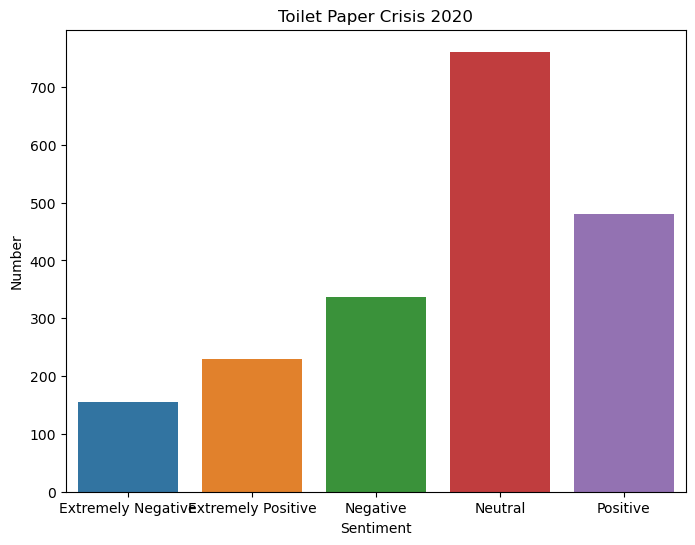

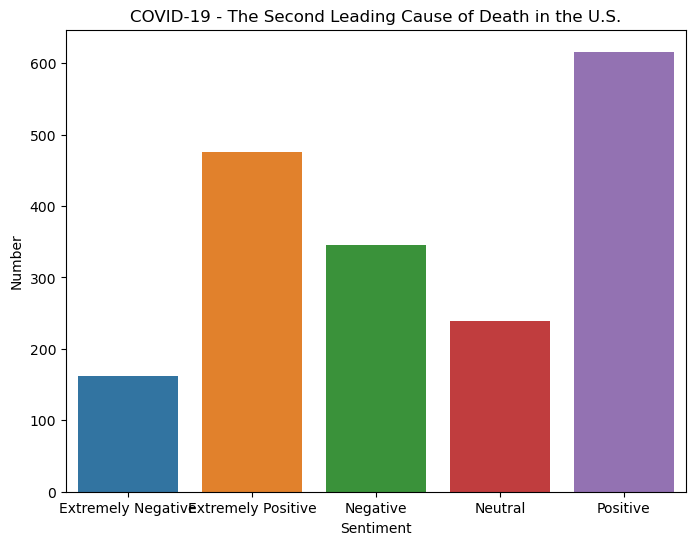

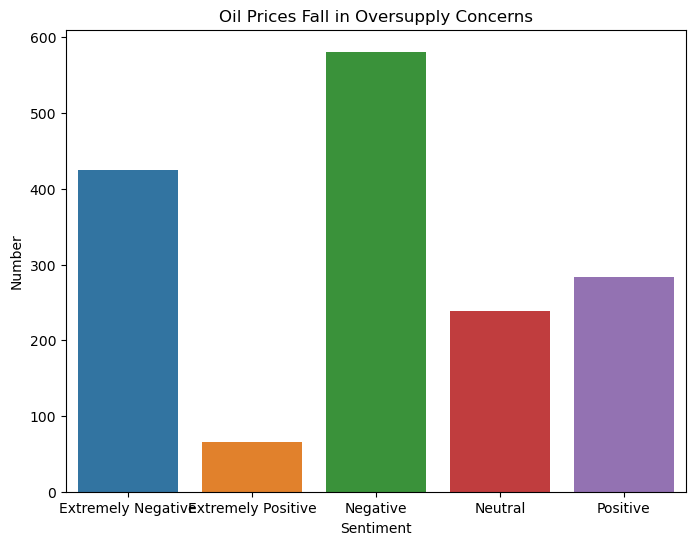

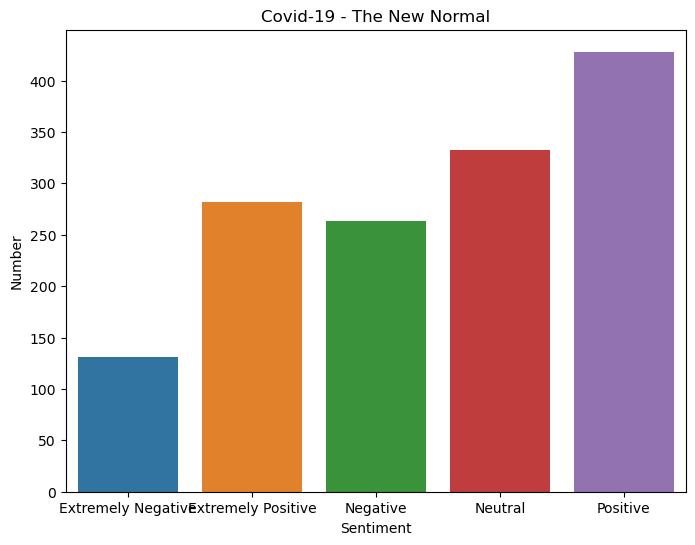

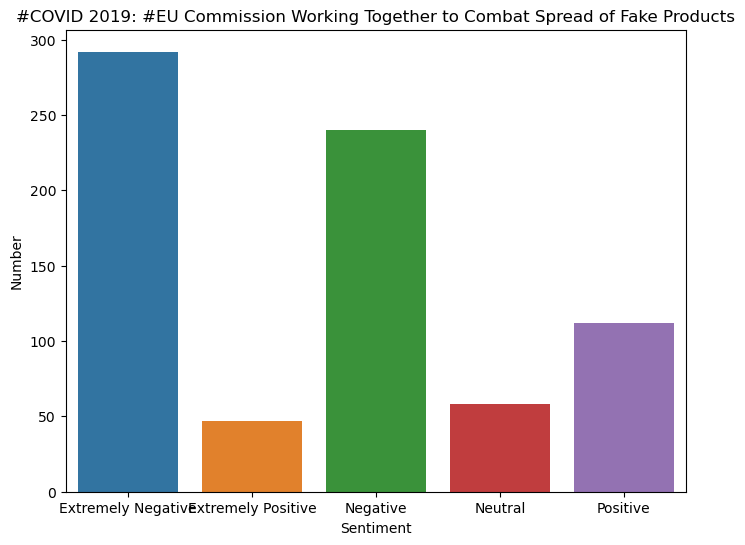

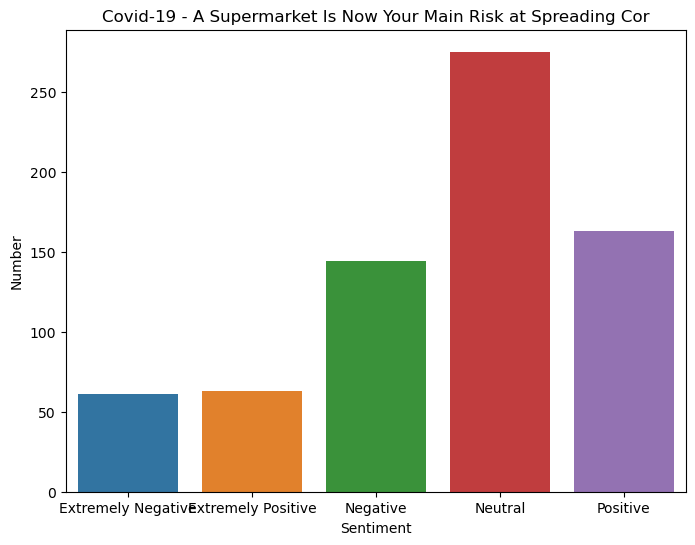

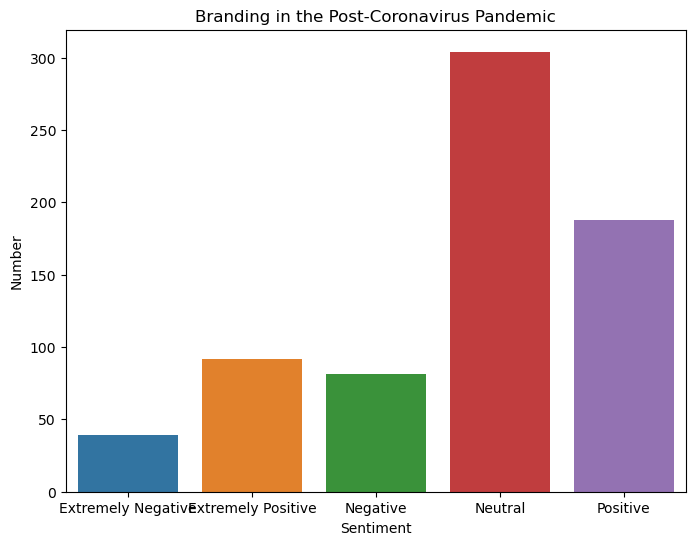

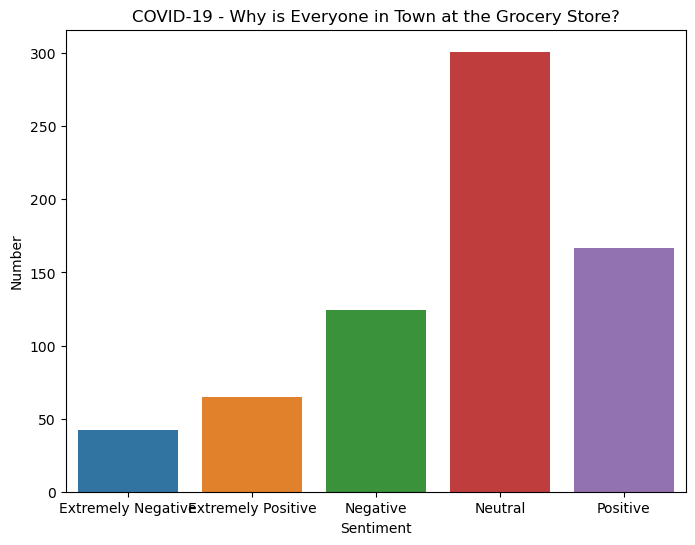

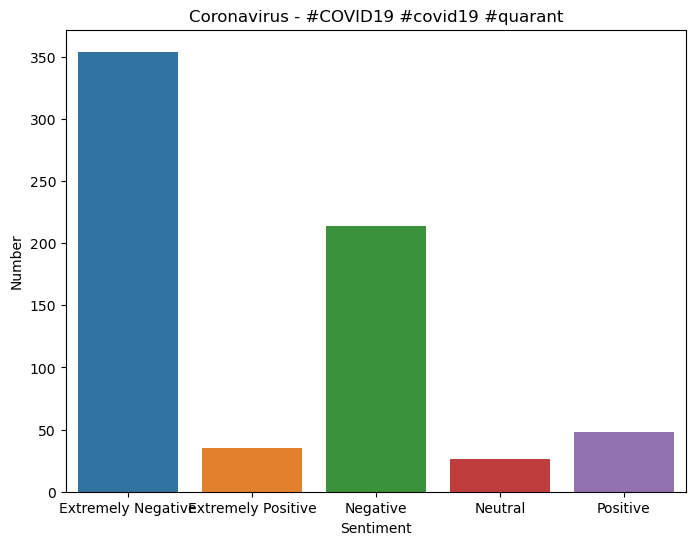

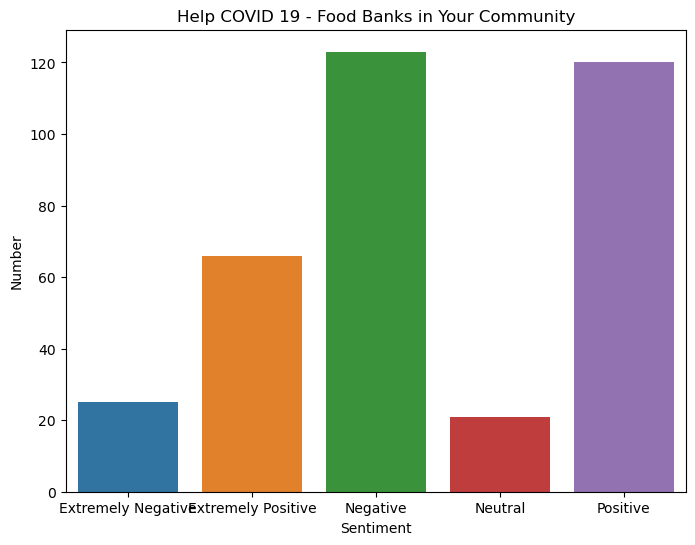

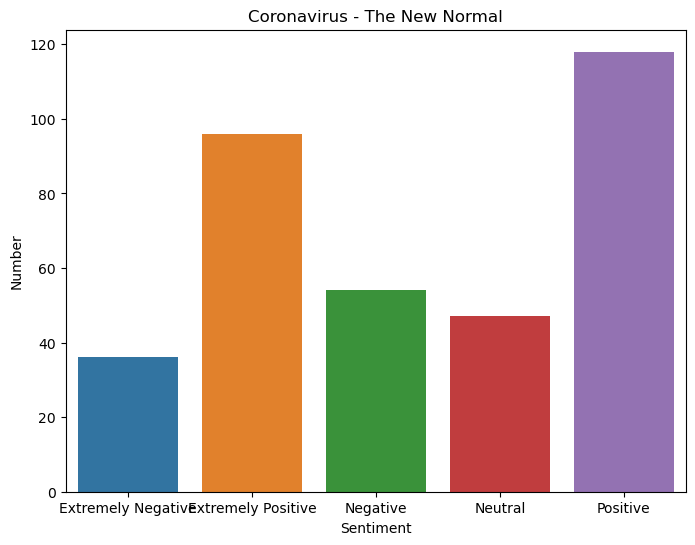

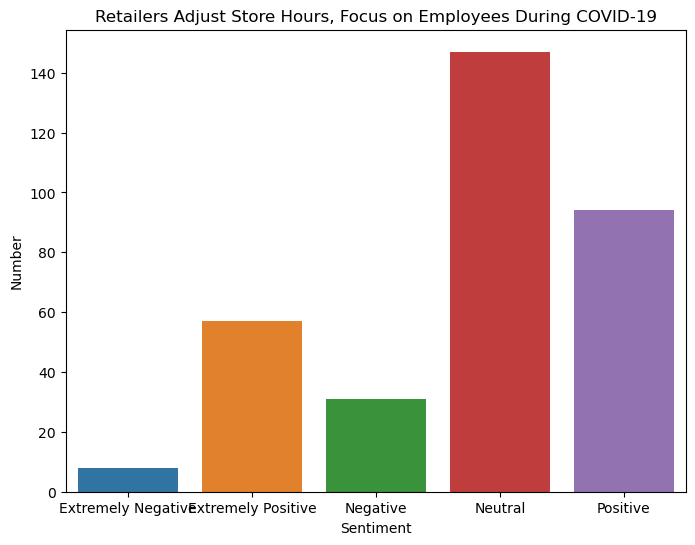

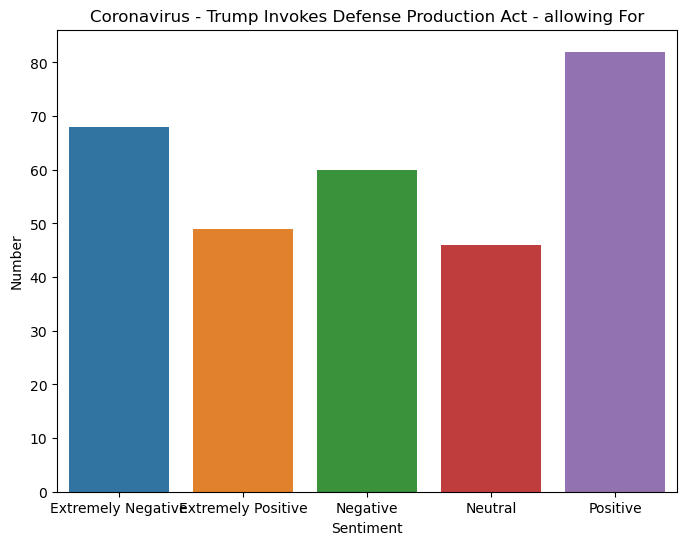

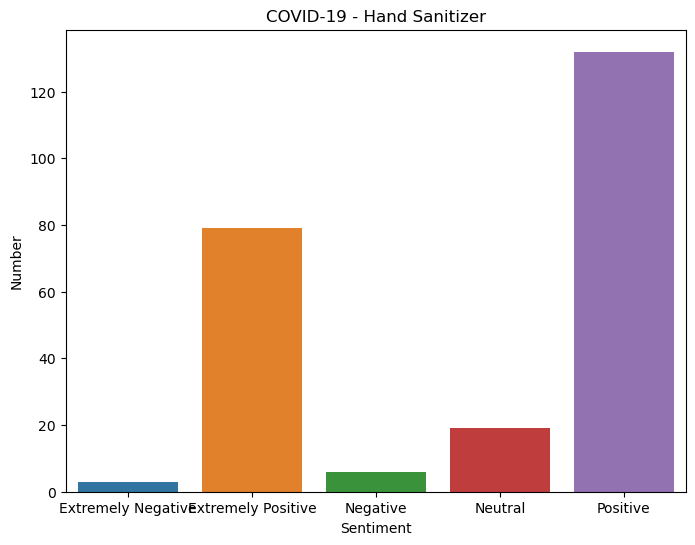

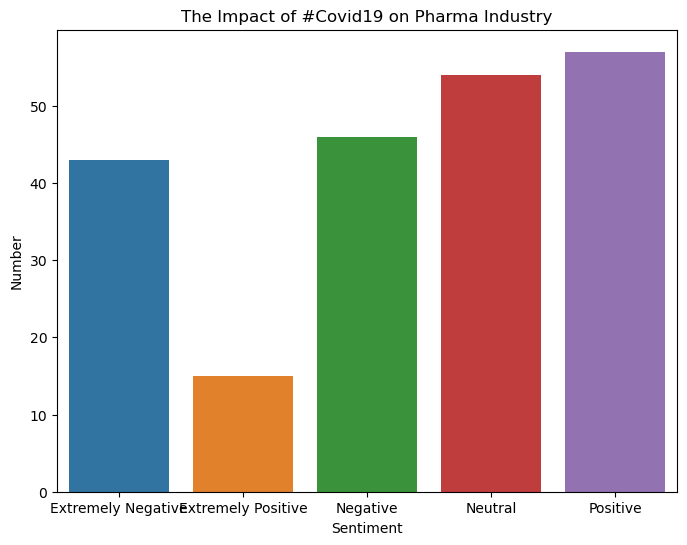

In [ ]:
import seaborn as sns

for idx, (topic, sentiment_lst, nums) in enumerate(list_analysis):
    df = pd.DataFrame({"Number":nums, "Sentiment":sentiment_lst})
    plt.figure(idx, figsize=(8, 6))
    plt.title(topic)
    sns.barplot(df, x="Sentiment", y="Number")
plt.show()
